In [1]:
%load_ext autoreload
%autoreload 2
import logging
import pandas as pd
import numpy as np
from hopfield import Hopfield
import tensorflow as tf
from topicpy import gtex
import multiprocessing as mp
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../datasets/gtex/10/topsbm/topsbm_level_3_topic-dist.csv', index_col=1).drop("i_doc", axis=1)
df=df.transpose().reset_index()
df.rename({"index":"id"}, axis=1, inplace=True)
#df.set_index("id", inplace=True)
df = df.set_index("id").transpose()
#df = df.subtract(df.mean(axis=0),1).abs().divide(df.std(axis=0),1) ## DNW
df = df.subtract(df.min(axis=0),1).abs().divide(df.max(axis=0)-df.min(axis=0),1) ## threshold should be 0.005
df.head(2)

id,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 136,Topic 137,Topic 138,Topic 139,Topic 140,Topic 141,Topic 142,Topic 143,Topic 144,Topic 145
doc,,,,,,,,,,,,,,,,,,,,,
GTEX-1GZ2Q-0011-R6a-SM-9OSWM,0.011178,0.005814,0.018415,0.006176,0.525943,0.001013,0.030416,0.000152,0.000148,0.000000,...,0.0,0.0,0.014663,0.004800,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-RU72-0011-R5A-SM-2TF6U,0.010504,0.006271,0.023932,0.007010,0.525912,0.001452,0.039782,0.000317,0.000124,0.001677,...,0.0,0.0,0.008129,0.006305,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_files = pd.read_csv('../datasets/gtex/10/files.dat', index_col=0).reindex(index=df.index)
df["tissue"] = df_files["SMTS"]

In [4]:
threshold_f = lambda p: p>0.005
data_df=df.groupby("tissue").mean().applymap(threshold_f).astype(int)
data_tensor = tf.convert_to_tensor(data_df.values*2-1, dtype=tf.int8)

In [264]:
model = Hopfield(data_df.shape[1])
model.load(data_tensor)
print(model)
model.train()

[2021-01-13 18:23:37,995] Creating model..
[2021-01-13 18:23:37,995] Creating model..
INFO:hopfield:Creating model..
[2021-01-13 18:23:38,012] Loading data...
[2021-01-13 18:23:38,012] Loading data...
INFO:hopfield:Loading data...


Hopfield model with 145 neurons and 10 memories loaded (max. 20) 


In [265]:
@tf.function
def hamming(A, B):
    assert(A.shape==B.shape)
    return tf.divide(tf.cast(tf.reduce_sum(tf.abs(tf.subtract(tf.cast(A, dtype=tf.int64),tf.cast(B, dtype=tf.int64)))), tf.float64), 2*tf.cast(A.shape[0], tf.float64))

def process_sample(sample):
    return df_threshold.loc[:,sample].values*2-1

def predict(sample, model):
        reconstructed = model.reconstruct(sample)
        return data_df.index[tf.argmin(tf.reduce_min([tf.concat([hamming(reconstructed, data), hamming(-reconstructed, data)], axis=0) for data in data_tensor], axis=1))]

In [266]:
logging.getLogger("hopfield").setLevel("INFO")

In [267]:
df_threshold = df.transpose().drop("tissue", axis=0).applymap(threshold_f).astype(int)
reals = []
preds = []

for sample in df.index:
    pred = predict(process_sample(sample), model)
    real = df.loc[sample,"tissue"]
    if type(real)!=str:
        real=real.values[0]
    reals.append(real)
    preds.append(pred)

In [268]:
print("Acc ",accuracy_score(reals, preds))
try:
    print("AUC ",roc_auc_score(tf.one_hot(tf.unique(preds)[1],3),tf.one_hot(tf.unique(reals)[1],3), multi_class="ovr"))
except:
    pass

Acc  0.669
AUC  0.6646726662180659


In [269]:
dist_matrix = tf.map_fn(lambda A: tf.map_fn(lambda B: tf.reduce_min([tf.cast(hamming(model.reconstruct(A),B),tf.float64),tf.cast(hamming(-model.reconstruct(A),B),tf.float64)]), tf.cast(data_tensor,tf.float64)), tf.cast(data_tensor,tf.float64)).numpy()

<AxesSubplot:>

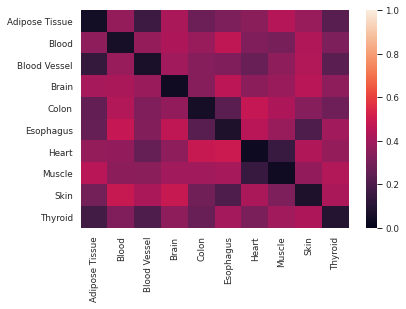

In [270]:
sns.heatmap(dist_matrix, vmin=0, vmax=1, xticklabels=data_df.index, yticklabels=data_df.index)

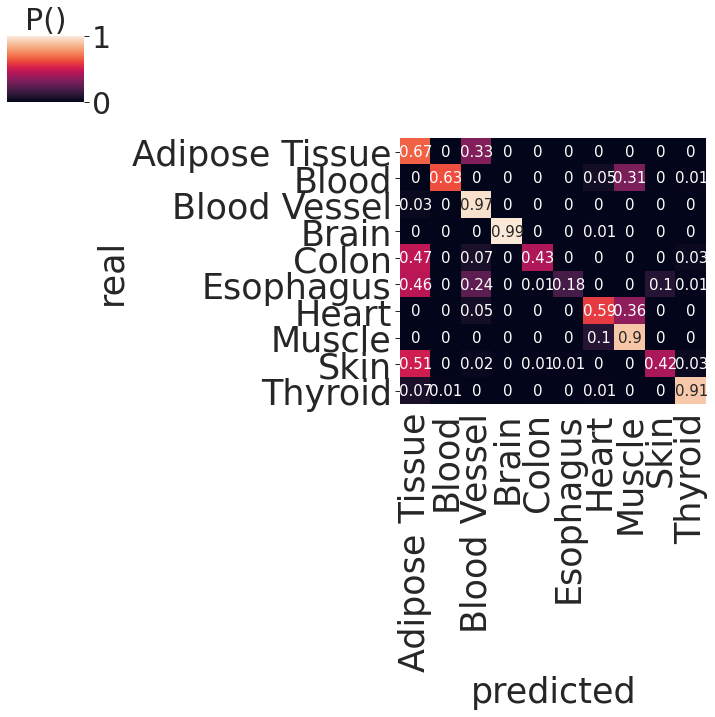

In [271]:
cm = sns.clustermap(confusion_matrix(reals, preds, normalize="true"),
                    vmin = 0,
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=data_df.index, 
                     yticklabels=data_df.index,
                    annot=True,
                    annot_kws={"fontsize":15})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=data_df.index, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=data_df.index, rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
#cm.savefig(f"predict_{label}.pdf")

plt.show()

In [272]:
for i,data in enumerate(data_tensor):
    print(data_df.index[i], predict(data, model))

Adipose Tissue Adipose Tissue
Blood Blood
Blood Vessel Blood Vessel
Brain Brain
Colon Colon
Esophagus Esophagus
Heart Heart
Muscle Muscle
Skin Skin
Thyroid Thyroid
